In [451]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [452]:
device = "cuda"

import yaml
import os
cfg_path = "checkpoints/final_model/config_medium.yaml"

with open(cfg_path) as f:
    cfg = yaml.safe_load(f)

cfg["device"] = device
cfg["model"]["patchify_args"]["device"] = device
cfg["model"]["unpatchify_args"]["device"] = device

from src.utils import load_model_from_config

model = load_model_from_config(cfg)

# Find and load last epoch in the directory
dir = os.path.join(cfg["training"]["checkpoint_dir"], "model")
last_epoch = max([int(f.split("_")[1].removesuffix(".pth")) for f in os.listdir(dir) if f.startswith("epoch_")], default=0)
model.load_model(os.path.join(dir, f"epoch_{last_epoch}.pth"))

model.eval()

/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


ALMTokenizer(
  (query_encoder): QueryEncoder(
    (layers): ModuleList(
      (0-11): 12 x RopeEncoderLayer(
        (q_proj): Linear(in_features=128, out_features=128, bias=False)
        (k_proj): Linear(in_features=128, out_features=128, bias=False)
        (v_proj): Linear(in_features=128, out_features=128, bias=False)
        (out_proj): Linear(in_features=128, out_features=128, bias=False)
        (rope): RotaryPositionalEmbeddings()
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=256, out_features=128, bias=True)
        )
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (query_decoder): QueryEncoder(
    (layers): ModuleList(
      (0-11): 12 x RopeEncoderLayer(
        (q_proj): Linear(in_features=128, out_features=128, bias=False)
        (k_proj

### Generate the embeddings

In [458]:
from src.datasets import GoodSoundsDataset



dataset = GoodSoundsDataset(root_dir="../good_sounds_dataset",
                            db_filename="good-sounds/database.sqlite")

from utils import save_codes_h5

save_codes_h5(
    dataset=dataset,
    model=model.eval(),
    h5_path="codes/good_sounds2.h5",
    device=device
)

/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
100%|██████████| 16308/16308 [03:10<00:00, 85.48it/s] 


Saved codes and metadata for 16308 samples to codes/good_sounds2.h5


### Structure the data

In [464]:
import h5py
from tqdm import tqdm
import torch

z = list()
z_attrs = list()

h = list()
h_attrs = list()

with h5py.File("codes/good_sounds2.h5", 'r') as f:
    # Get the mean of each sample's codes
    for i, key in tqdm(enumerate(f.keys())):
        grp = f[key]

        keys = ["sound_id", "instrument", "note", "octave", "klass"]
        res_dict = dict()
        for key in keys:
            res_dict[key] = grp.attrs.get(key, "unknown")
        try:
            z_mat = grp["z_level_0"][:].T
            if z_mat.ndim == 1:
                z_mat = z_mat[torch.newaxis, :]
            print(z_mat.shape)
            z_attrs += [res_dict] * z_mat.shape[0]
            z.append(z_mat)

            h_mat = grp["h_level_0"][:]
            if h_mat.ndim == 1:
                h_mat = h_mat[torch.newaxis, :]
            print(h_mat.shape)
            h_attrs += [res_dict] * h_mat.shape[0]
            h.append(h_mat)
        except Exception as e:
            print(f"Error processing group {key}: {e}")

194it [00:00, 976.28it/s]

(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(309, 128)
(103, 128)
(309, 128)
(103, 128)
(309, 128)
(103, 128)
(262, 128)
(88, 128)
(262, 128)
(88, 128)
(262, 128)
(88, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(268, 128)
(90, 128)
(268, 128)
(90, 128)
(268, 128)
(90, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(306, 128)
(102, 128)
(306, 128)
(102, 128)
(306, 128)
(102, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(339, 128)
(113, 128)
(339, 128)
(113, 128)
(339, 128)
(113, 128)
(306, 128)
(102, 128)
(306, 128)
(102, 128)
(306, 128)
(102, 128)
(273, 128)
(91, 128)
(273, 128)
(91, 128)
(273, 128)
(91, 128)
(328, 1

507it [00:00, 1385.35it/s]

(189, 128)
(63, 128)
(186, 128)
(62, 128)
(186, 128)
(62, 128)
(158, 128)
(53, 128)
(158, 128)
(53, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(190, 128)
(64, 128)
(190, 128)
(64, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(225, 128)
(75, 128)
(225, 128)
(75, 128)
(234, 128)
(78, 128)
(234, 128)
(78, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(257, 128)
(86, 128)
(257, 128)
(86, 128)
(257, 128)
(86, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(239, 128)
(80, 128)
(239, 128)
(80, 128)
(291, 128)
(97, 128)
(291, 128)
(97, 128)
(204, 128)
(68, 128)
(204, 128)
(68, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 

646it [00:00, 1299.68it/s]

(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(315, 128)
(105, 128)
(315, 128)
(105, 128)
(315, 128)
(105, 128)
(293, 128)
(98, 128)
(293, 128)
(98, 128)
(293, 128)
(98, 128)
(300, 128)
(100, 128)
(300, 128)
(100, 128)
(300, 128)
(100, 128)
(225, 128)
(75, 128)
(225, 128)
(75, 128)
(225, 128)
(75, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 

976it [00:00, 1493.63it/s]

(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(205, 128)
(69, 128)
(205, 128)
(69, 128)
(205, 128)
(69, 128)
(249, 128)
(83, 128)
(249, 128)
(83, 128)
(249, 128)
(83, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(

1290it [00:00, 1523.42it/s]

(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(258, 128)
(86, 128)
(258, 128)
(86, 128)
(258, 128)
(86, 128)
(245, 128)
(82, 128)
(245, 128)
(82, 128)
(245, 128)
(82, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(244, 128)
(82, 128)
(244, 128)
(82, 128)
(244, 128)
(82, 128)
(269, 128)
(90, 128)
(269, 128)
(90, 128)
(269, 128)
(90, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(

1614it [00:01, 1539.43it/s]

(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(235, 128)
(79, 128)
(235, 128)
(79, 128)
(235, 128)
(79, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(253, 128)
(85, 128)
(253, 128)
(85, 128)
(253, 128)
(85, 128)
(253, 128)
(85, 128)
(253, 128)
(85, 128)
(253, 128)
(85, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(

1933it [00:01, 1567.15it/s]

(103, 128)
(308, 128)
(103, 128)
(308, 128)
(103, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)


2232it [00:01, 1285.42it/s]

(434, 128)
(145, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(213, 128)
(71, 128)
(213, 128)
(71, 128)
(213, 128)
(71, 128)
(459, 128)
(153, 128)
(459, 128)
(153, 128)
(632, 128)
(211, 128)
(632, 128)
(211, 128)
(400, 128)
(134, 128)
(400, 128)
(134, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(400, 128)
(134, 128)
(400, 128)
(134, 128)
(329, 128)
(110, 128)
(329, 128)
(110, 128)
(357, 128)
(119, 128)
(357, 128)
(119, 128)
(222, 128)
(74, 128)
(222, 128)
(74, 128)
(222, 128)
(74, 128)
(372, 128)
(124, 128)
(372, 128)
(124, 128)
(321, 128)
(107, 128)
(321, 128)
(107, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(384, 128)
(128, 128)
(384, 128)
(128, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(391, 128)
(131, 128)
(3

2365it [00:01, 1240.89it/s]

(1, 128)
(1, 128)
(1, 128)
(1, 128)
(292, 128)
(98, 128)
(292, 128)
(98, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(211, 128)
(71, 128)
(211, 128)
(71, 128)
(211, 128)
(71, 128)
(273, 128)
(91, 128)
(273, 128)
(91, 128)
(273, 128)
(91, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(396, 128)
(132, 128)
(396, 128)
(132, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(330, 128)
(110, 128)
(330, 128)
(110, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(212, 128)
(71, 128)
(212, 128)
(71, 128)
(212, 128)
(71, 128)
(316, 128)
(106, 128)
(316, 128)
(106, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(275, 128)
(92, 128)
(275, 128)
(92, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(292, 128)
(98, 128)
(292, 128)
(98, 128)
(262, 128)
(88, 128)
(262, 128)
(88, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128

2705it [00:01, 1409.63it/s]


(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(

In [465]:
import numpy as np
z_res = np.vstack(z)
h_res = np.vstack(h)

In [466]:
import gc
del z
del h
gc.collect()

0

In [467]:
import pandas as pd

z_attributes = pd.DataFrame(z_attrs)
h_attributes = pd.DataFrame(h_attrs)
X = pd.concat([pd.DataFrame(z_res), pd.DataFrame(h_res)], keys=["EnCodec", "ALMTokenizer"])
df = pd.concat([z_attributes, h_attributes], keys=["EnCodec", "ALMTokenizer"])

### Define the labels

In [471]:
# Transform labels to integer indices
from sklearn.preprocessing import LabelEncoder

def generate_label_encoder(df, keys):
    encoders = dict()
    num_labels = df.copy()
    for key in keys:
        le = LabelEncoder()
        le.fit(df[key])
        encoders[key] = le
        num_labels[key] = le.transform(df[key])
    return encoders, num_labels

def get_good_bad(label: str) -> str:
    if not label or label.strip() == "":
        return "other"
    if "good" in label:
        return "good"
    if "bad" in label:
        return "bad"
    return "other"

df["klass"] = df["klass"].apply(get_good_bad)
attributes = ["instrument", "note", "octave", "klass"]
label_encoders, num_labels = generate_label_encoder(df, attributes)

In [472]:
import pandas as pd
from sklearn.model_selection import train_test_split

def stratified_sample(df, source_col="source", n=100, group_cols=("instrument", "note", "octave", "klass"), random_state=0):
    df = df.copy()
    # Create a combined label for stratification
    
    sample_indices = []
    for src, d in df.groupby(level=0):
        strata = d[list(group_cols)].astype(str).agg("_".join, axis=1)
        # If not enough rows, just take all
        n_target = min(n, len(d))
        if n_target == len(d):
            sample_indices += d
        else:
            # Stratified downsample
            s, _ = train_test_split(
                d, train_size=n_target, 
                stratify=strata, 
                random_state=random_state
            )
            sample_indices += s.index.tolist()

    return sample_indices

In [ ]:
indices = stratified_sample(
    df, 
    source_col="source",
    n=50000,
    group_cols=("instrument", "note"),
    random_state=123
)


In [474]:
df_subset = df.loc[indices]
x_subset = X.loc[indices]
num_labels_subset = num_labels.loc[indices]

In [495]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt
from matplotlib import cm

def projection(x, labels_df, columns, proj_fn=TSNE, y=None, proj_fn_kwargs={}, transform_kwargs={}, plot_kwargs={}):

    proj = proj_fn(**proj_fn_kwargs)
    
    if y is not None:
        y_grp = y
        coords = proj.fit_transform(x, y_grp, **transform_kwargs)

    else:
        coords = proj.fit_transform(x, **transform_kwargs)

    fig, axs = plt.subplots(1, len(columns), figsize=(20, 5))
    try:
        axs = axs.flatten()
    except AttributeError:
        axs = [axs]
        print("Ha pasao")

    labels = labels_df
    for ax, key in zip(axs, columns):
        colors = cm.get_cmap("tab10", len(labels_df[key].unique()))
        for label, c in zip(labels_df[key].unique(), colors.colors.tolist()):
            # Get coordinates for the current label
            grp_coords = coords[labels[key] == label]
            ax.scatter(grp_coords[:, 0], grp_coords[:, 1], color=c, s=1.5, cmap="tab10", label=label)
        ax.set_title(key)
        xlabel = plot_kwargs.get("xlabel", "Axis 1")
        ax.set_xlabel(xlabel)

        ylabel = plot_kwargs.get("ylabel", "Axis 2")
        ax.set_ylabel(ylabel)
        
        ax.legend(loc='upper right', fontsize='small', markerscale=2, ncol=2)
        ax.set_aspect("equal")

    if "suptitles" in plot_kwargs:
        suptitle = plot_kwargs["suptitles"][i]
        fig.suptitle(suptitle, fontsize=16, y=1.1)
    fig.show()



/tmp/ipykernel_5641/798587213.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


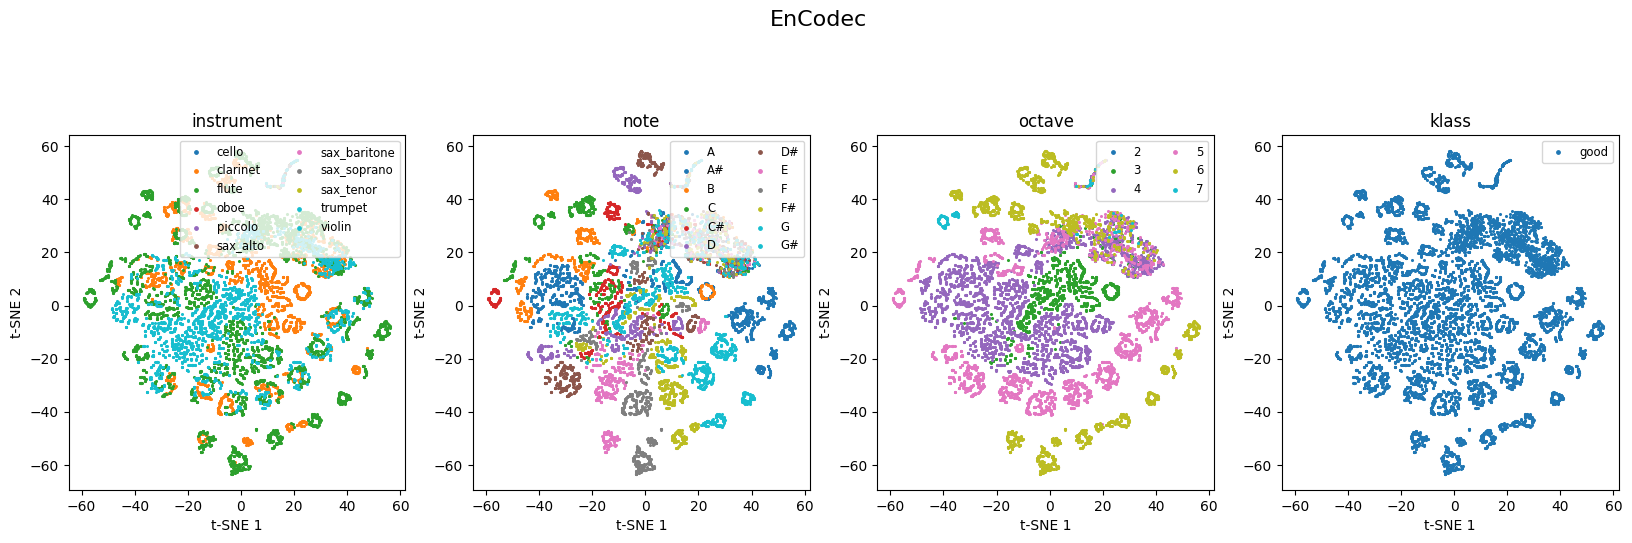

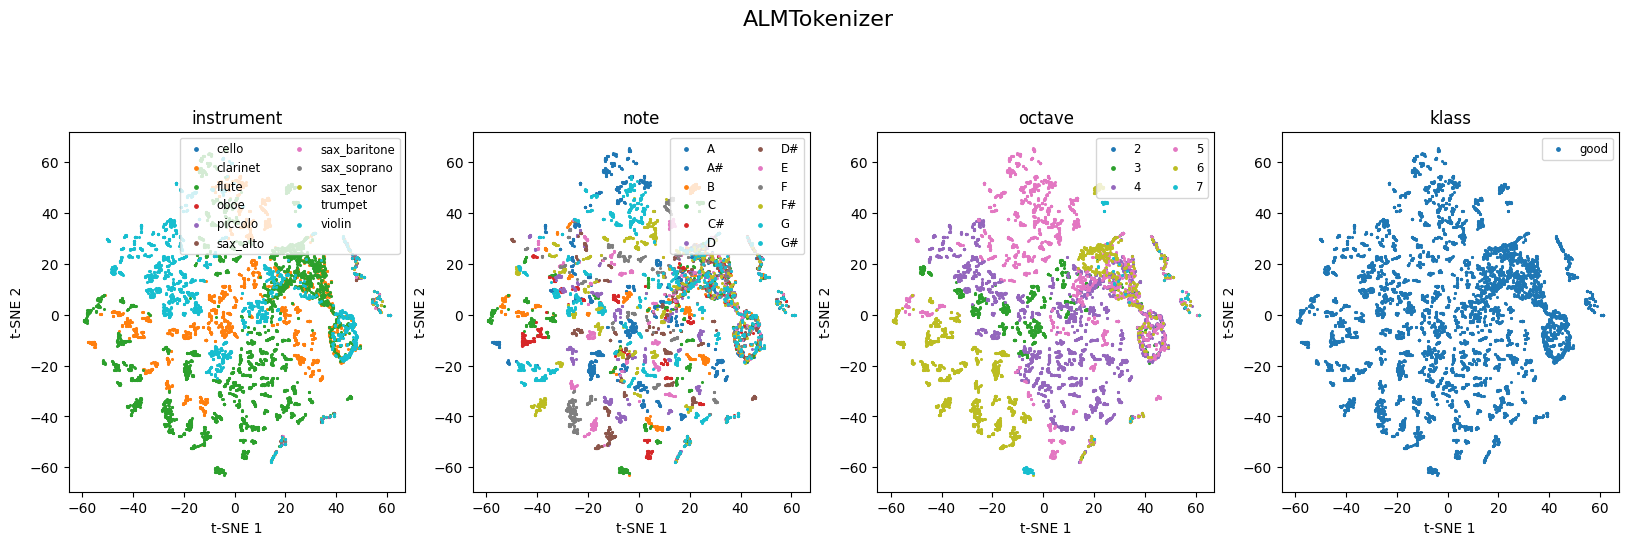

In [ ]:
plot_kwargs = {
    "xlabel": "t-SNE 1",
    "ylabel": "t-SNE 2",
}

for method in x_subset.index.levels[0]:
    x_grp = x_subset.loc[method]
    df_grp = df_subset.loc[method]
    projection(x_grp, df_grp, attributes, label_encoders, TSNE, proj_fn_kwargs={'n_jobs': -1}, plot_kwargs=plot_kwargs)

By Instrument
By Note


/tmp/ipykernel_5641/798587213.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_5641/798587213.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_5641/798587213.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_5641/798587213.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


By Octave


/tmp/ipykernel_5641/798587213.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_5641/798587213.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


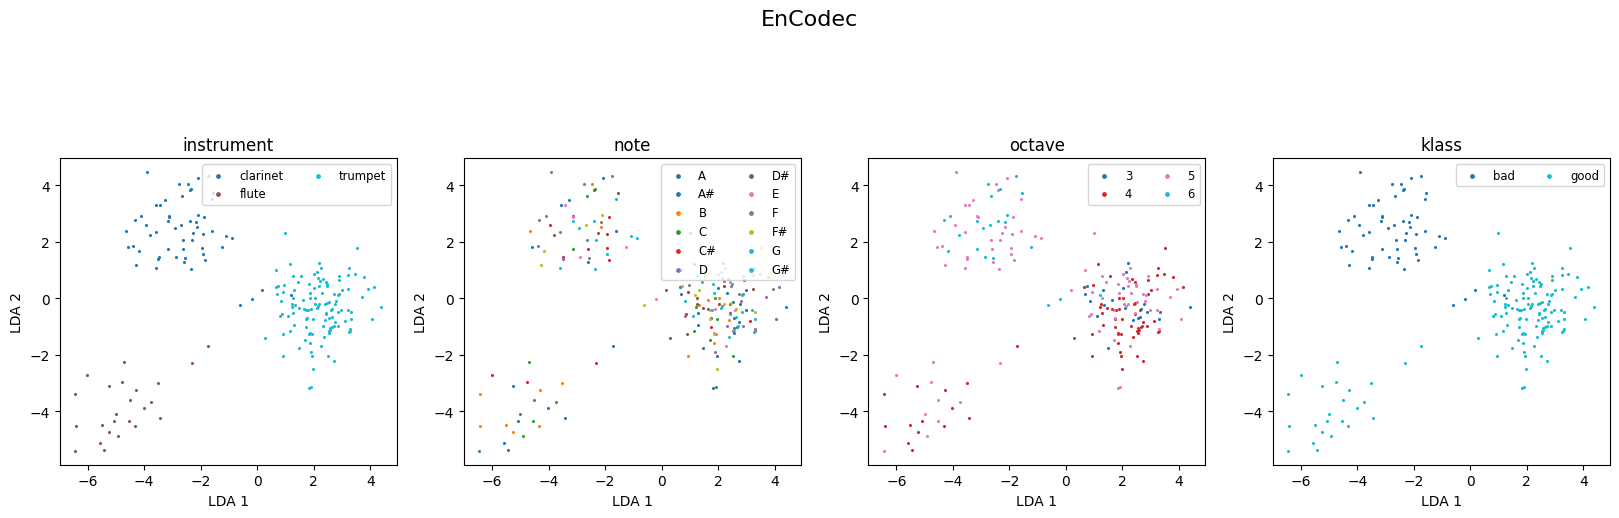

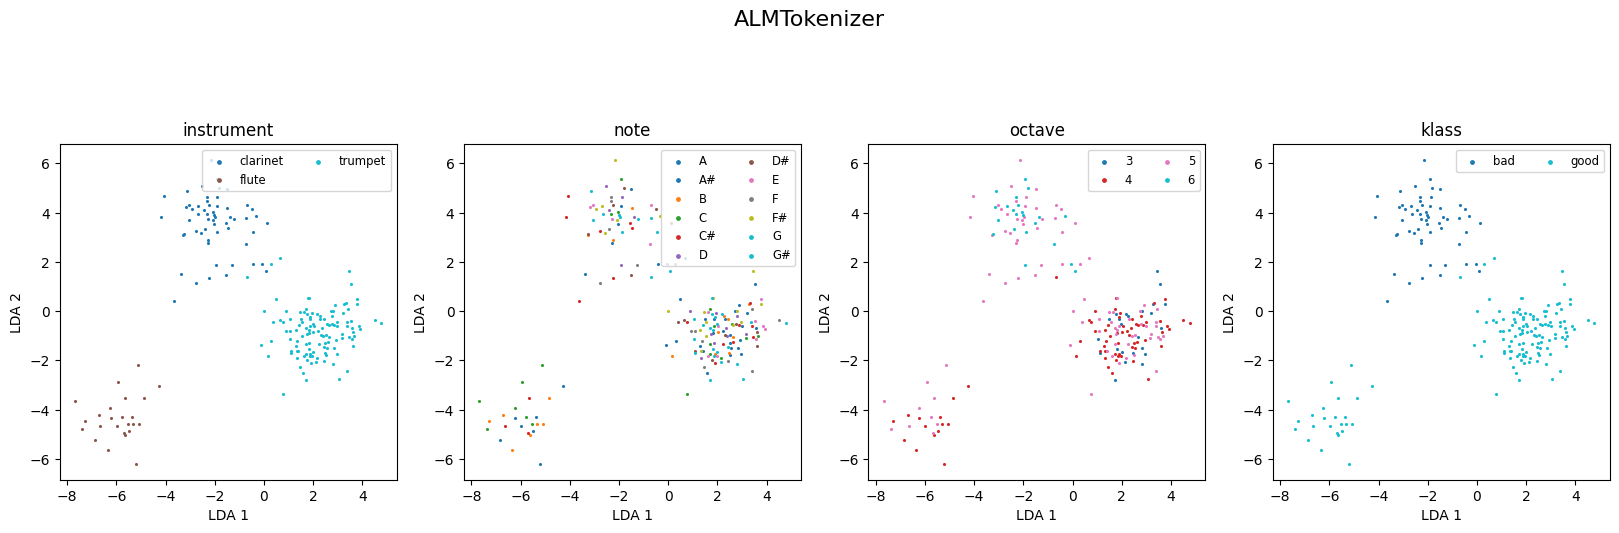

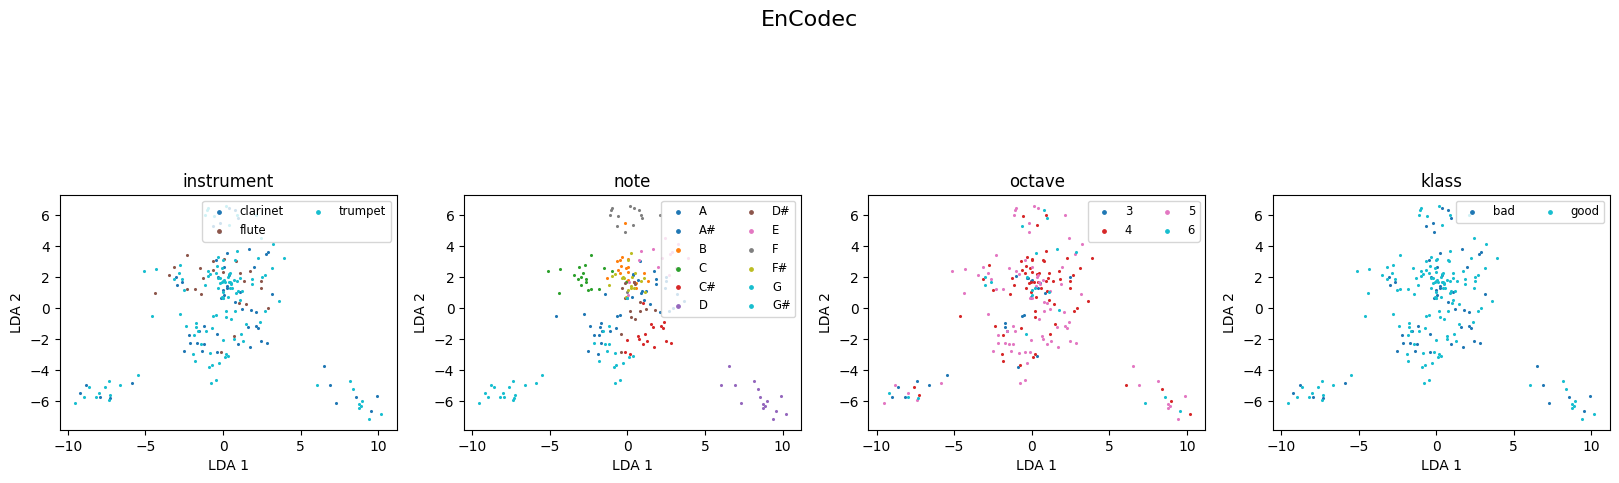

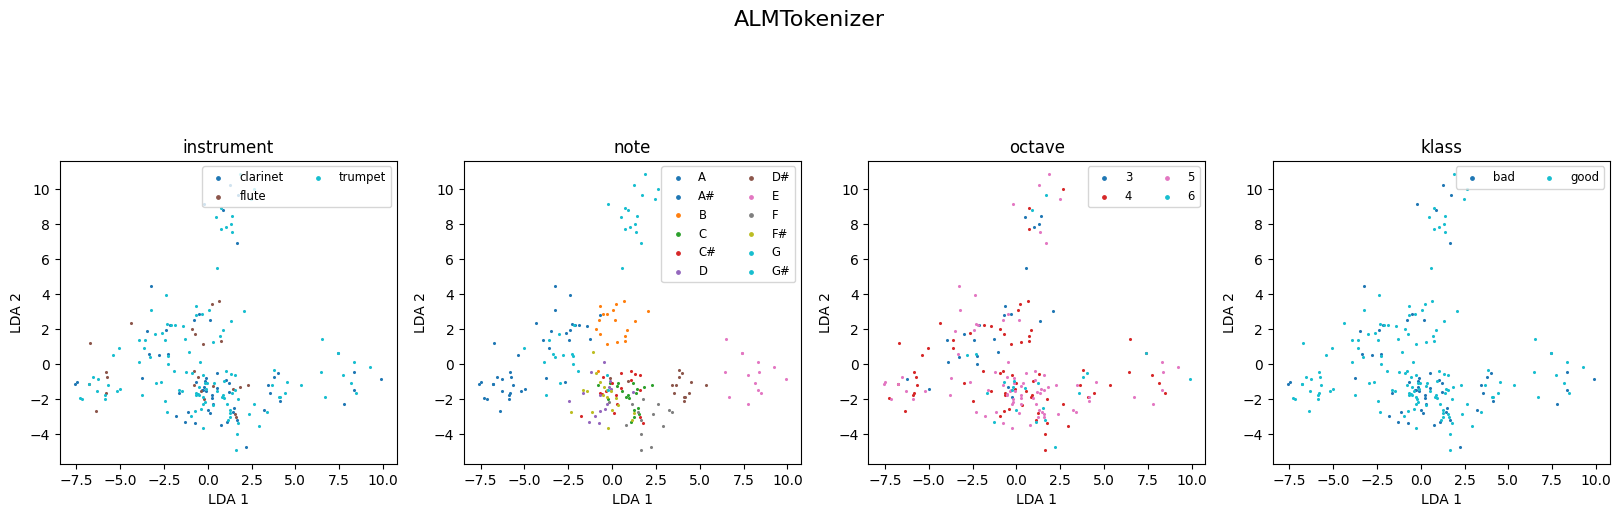

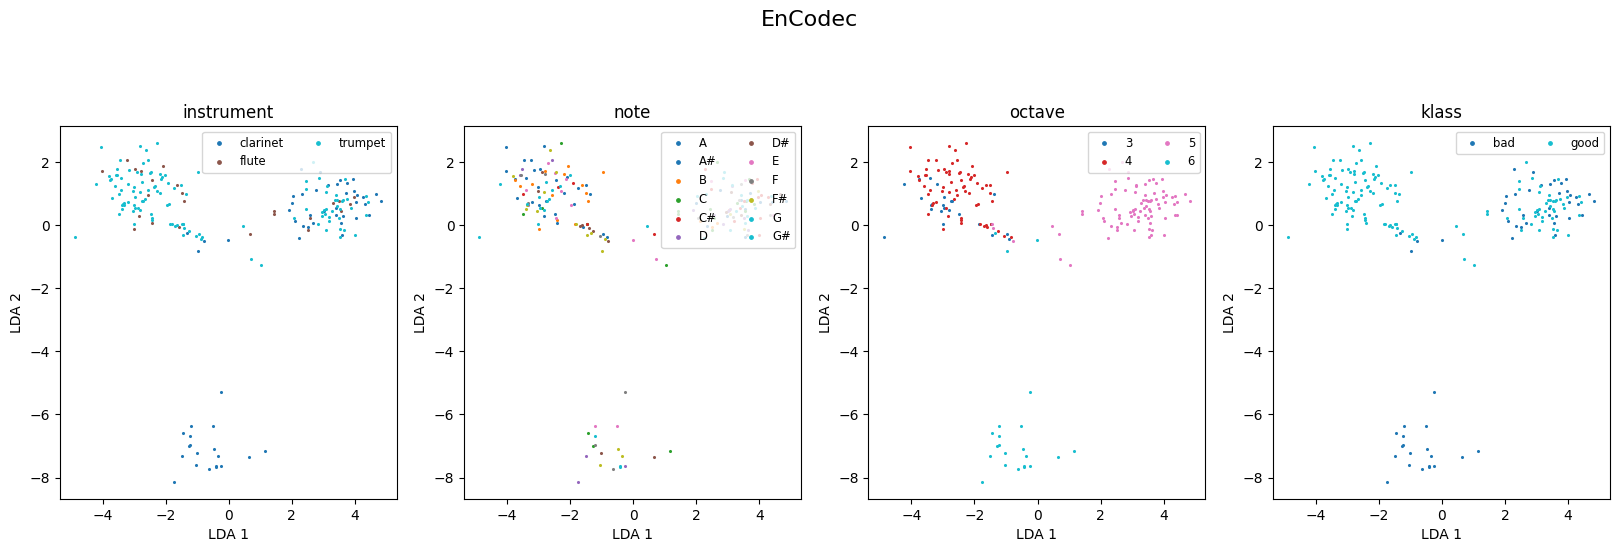

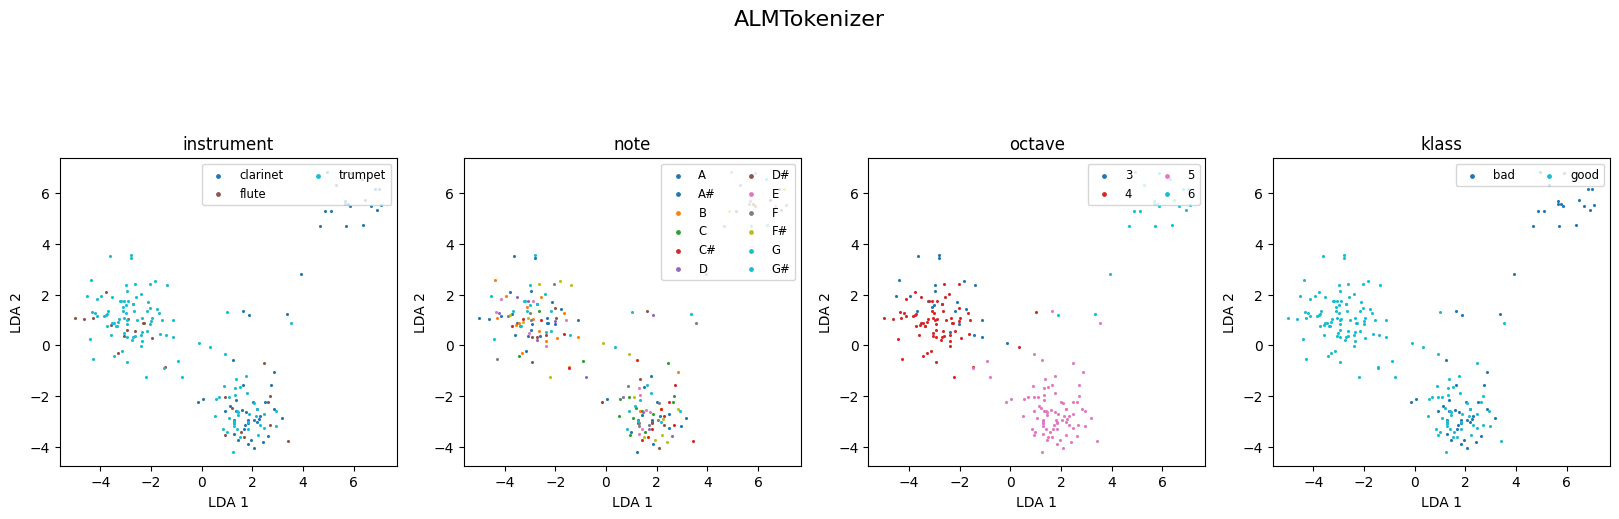

In [ ]:
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

plot_kwargs = {
    "xlabel": "LDA 1",
    "ylabel": "LDA 2",
}

print("By Instrument")
for method in x_subset.index.levels[0]:
    x_grp = x_subset.loc[method]
    df_grp = df_subset.loc[method]
    projection(x_grp, df_grp, attributes, label_encoders, LDA, y=df_grp["instrument"], plot_kwargs=plot_kwargs)

print("By Note")
for method in x_subset.index.levels[0]:
    x_grp = x_subset.loc[method]
    df_grp = df_subset.loc[method]
    projection(x_grp, df_grp, attributes, label_encoders, LDA, y=df_grp["note"], plot_kwargs=plot_kwargs)

print("By Octave")
for method in x_subset.index.levels[0]:
    x_grp = x_subset.loc[method]
    df_grp = df_subset.loc[method]
    projection(x_grp, df_grp, attributes, label_encoders, LDA, y=df_grp["octave"], plot_kwargs=plot_kwargs)

# Clustering

100%|██████████| 19/19 [00:54<00:00,  2.86s/it]
/tmp/ipykernel_5641/678295209.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_5641/2749778999.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Ha pasao


100%|██████████| 19/19 [00:54<00:00,  2.89s/it]
/tmp/ipykernel_5641/678295209.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Ha pasao


/tmp/ipykernel_5641/2749778999.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


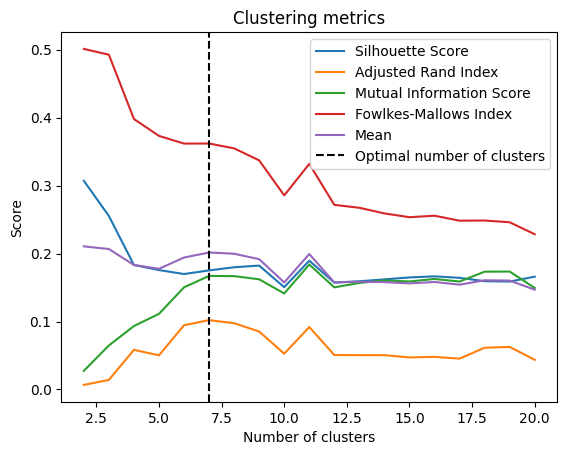

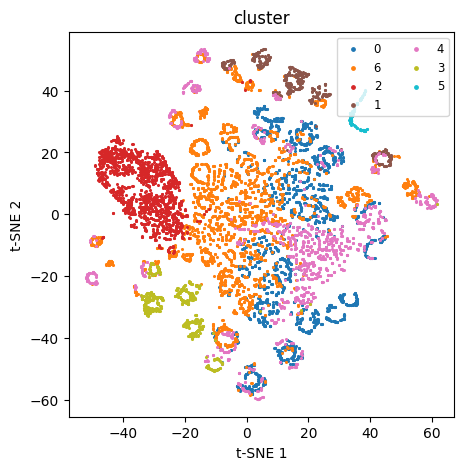

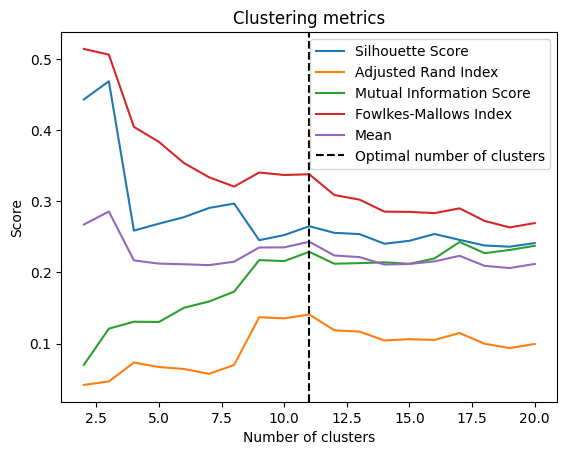

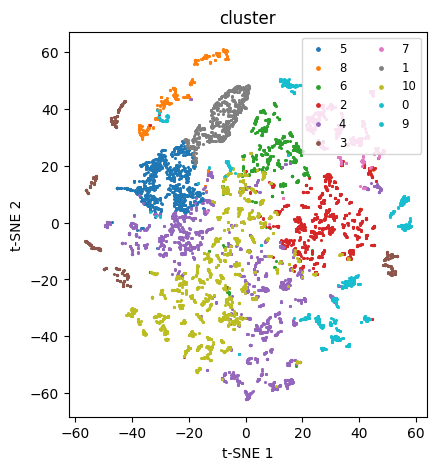

In [498]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, silhouette_score

def scan_k(x, true_labels, k_range):

    # Initialize lists to store metrics
    rands = list()
    mis = list()
    fmis = list()
    sil = list()
    bics = list()
    aics = list()
    ks = list()

    for k in k_range:
        kmean = KMeans(n_clusters=k)
        clusters = kmean.fit_predict(x)

        # Compute clustering metrics
        sil.append(silhouette_score(x, clusters))
        rands.append(adjusted_rand_score(true_labels, clusters))
        mis.append(normalized_mutual_info_score(true_labels, clusters))
        fmis.append(fowlkes_mallows_score(true_labels, clusters))
        ks.append(k)

    # Create a figure and axis
    fig, axs = plt.subplots(1, 1)

    # Plot the Silhouette Score
    axs.plot(ks, sil, label="Silhouette Score")

    # Plot the Adjusted Rand Index
    axs.plot(ks, rands, label="Adjusted Rand Index")

    # Plot the Mutual Information Score
    axs.plot(ks, mis, label="Mutual Information Score")

    # Plot the Fowlkes-Mallows Index
    axs.plot(ks, fmis, label="Fowlkes-Mallows Index")

    # Plot the mean of all metrics
    axs.plot(ks, np.mean([sil, rands, mis, fmis], axis=0), label="Mean")

    # Add a vertical line for the optimal number of clusters
    optim_n = min(ks) + np.argmax(np.mean([rands, mis, fmis], axis=0))
    axs.axvline(optim_n, color='black', linestyle='--', label="Optimal number of clusters")

    # Add legend to the plot
    axs.legend()

    # Set the title of the plot
    axs.set_title("Clustering metrics")

    # Set the labels of the plot
    axs.set_xlabel("Number of clusters")
    axs.set_ylabel("Score")

    fig.show()
    return optim_n

from tqdm import trange

for method in ["EnCodec", "ALMTokenizer"]:
    optim_n = scan_k(x_subset.loc[method], df_subset.loc[method]["instrument"], trange(2, 21))

    kmeans = KMeans(n_clusters=optim_n)
    clusters = kmeans.fit_predict(x_subset.loc[method])

    cluster_df = df_subset.loc[method].copy()
    cluster_df["cluster"] = clusters
    attributes = ["cluster"]
    projection(x_subset.loc[method], cluster_df, attributes, proj_fn=TSNE, proj_fn_kwargs={'n_jobs': -1}, plot_kwargs=plot_kwargs)

# Linear Separability Tests

In [ ]:
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

def linear_separability_test(label_encoders, x, num_labels):
    for key in label_encoders.keys():
        X_train, X_test, y_train, y_test = train_test_split(x, num_labels[key], test_size=0.2, random_state=42, stratify=num_labels[key])
        svm = SVC(kernel='linear', C=1, random_state=42)
        svm.fit(X_train, y_train)
        accuracy = svm.score(X_test, y_test)
        print(f"SVM accuracy for {key}: {accuracy:.2f}")

for method in ["encodec", "alm"]:
    print(f"Testing linear separability for {method}")
    linear_separability_test(label_encoders, x_subset.loc[method], num_labels_subset.loc[method])
    print()

Testing linear separability for encodec
SVM accuracy for instrument: 0.85
SVM accuracy for note: 0.50
SVM accuracy for octave: 0.60
SVM accuracy for klass: 0.70

Testing linear separability for alm
SVM accuracy for instrument: 0.72
SVM accuracy for note: 0.38
SVM accuracy for octave: 0.75
SVM accuracy for klass: 0.88



# Interpolation test

In [528]:
df["note"].unique()

array(['A#', 'A', 'G#', 'G', 'F#', 'F', 'E', 'D#', 'D', 'C#', 'B', 'C'],
      dtype=object)

In [546]:

import torch
from collections import defaultdict

def create_vectors(trajectory, df, x):
    keys = list(trajectory.keys())
    Ls = [len(trajectory[k]) for k in keys]
    if len(set(Ls)) != 1:
        raise ValueError(f"All trajectory lists must be the same length; got lengths {dict(zip(keys, Ls))}")

    vectors = []
    for i in range(len(trajectory[keys[0]])):
        elem_masks = []
        for key in keys:
            elem_masks.append(df[key] == trajectory[key][i])
        reduced_mask = np.logical_and.reduce(elem_masks)
        vectors.append(torch.tensor(x[reduced_mask].mean(axis=0)).unsqueeze(0).unsqueeze(0))

    return vectors

def interpolate_latent(*vectors, n):
    """
    Linearly interpolate n steps between vectors h1 and h2.

    Args:
        h1 (array-like, shape (D,)): Start latent vector.
        h2 (array-like, shape (D,)): End latent vector.
        n (int): Number of interpolation points (including h1 and h2).

    Returns:
        np.ndarray of shape (n, D): Interpolated vectors.
    """
    interpolated = []
    for i in range(len(vectors) - 1):
        h1 = np.asarray(vectors[i])
        h2 = np.asarray(vectors[i + 1])
        # 1. Create n weights from 0.0 to 1.0
        alphas = np.linspace(0.0, 1.0, num=n)
        # 2. Compute each interpolation: (1-α)*h1 + α*h2
        interpolated.append(torch.tensor([(1.0 - a) * h1 + a * h2 for a in alphas]).squeeze(1))
    
    return torch.cat(interpolated)

trajectory = {
    "instrument": ["clarinet", "cello"],
    "note": ["A", "A"],
    "octave": ["5", "2"],
    #"klass": ["good", "good"]
}

from encodec import EncodecModel
encodec_dec = EncodecModel.encodec_model_24khz().decoder.to(device)

#vector_list = create_vectors(trajectory, df_subset, x_subset)

enc_n_latents = 750
alm_n_latents = enc_n_latents // (model.window_size + 1)

audios = dict()

with torch.no_grad():
    # Compute EnCodec audio
    vector_list = create_vectors(trajectory, df_subset.loc["EnCodec"], x_subset.loc["EnCodec"])
    print(vector_list)
    seq = interpolate_latent(*vector_list, n=enc_n_latents)
    seq = torch.tensor(seq, dtype=torch.float32).to(device)
    seq = seq.permute(0, 2, 1)
    x_hat = encodec_dec(seq).flatten()
    audios["EnCodec"] = x_hat.cpu().detach().numpy()

    # Compute ALMTokenizer audio
    vector_list = create_vectors(trajectory, df_subset.loc["ALMTokenizer"], x_subset.loc["ALMTokenizer"])
    seq = interpolate_latent(*vector_list, n=alm_n_latents)
    seq = torch.tensor(seq, dtype=torch.float32).to(device)
    x_hat = model.decode(seq).flatten()
    audios["ALMTokenizer"] = x_hat.cpu().detach().numpy()


[tensor([[[ 1.6717e+00,  1.1184e+01, -2.1088e+00, -2.7889e+00, -5.2771e-01,
           6.8848e+00, -4.1219e+00,  4.9343e-01, -1.6586e+00,  4.2763e+00,
           7.0257e-01, -4.2157e-01,  2.0554e+00, -7.3017e+00,  6.8894e-01,
          -9.3880e+00, -1.2226e+00,  4.6116e+00, -1.0964e+00,  1.0884e+00,
          -1.1932e+01, -3.7600e+00, -2.3917e+00, -1.2888e+00,  7.5126e+00,
          -3.4501e-01,  1.0252e+01, -3.5614e+00, -5.6443e+00, -4.7892e+00,
          -8.4489e+00,  4.0393e+00,  2.4755e+00, -5.7921e+00,  3.0550e+00,
          -2.5851e+00, -2.7069e+00, -1.0515e+01,  1.6055e+00,  3.4443e+00,
           4.1967e+00,  4.2378e+00,  1.3338e+01,  1.2126e+00,  2.5498e+00,
          -1.4055e+00, -4.1335e+00,  4.1866e+00,  1.3141e+00, -4.8711e+00,
          -2.7619e+00, -7.2463e+00,  8.1180e-02,  2.7257e+00, -8.0150e+00,
           3.4004e+00, -1.8445e+00, -4.9230e+00, -2.7799e+00, -2.6938e-01,
          -7.3190e+00, -4.6303e+00,  2.7472e-01, -3.9127e+00, -5.5425e+00,
          -1.5095e+00,  

/tmp/ipykernel_5641/1920705501.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq = torch.tensor(seq, dtype=torch.float32).to(device)
/tmp/ipykernel_5641/1920705501.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq = torch.tensor(seq, dtype=torch.float32).to(device)


In [547]:
from IPython.display import Audio, display

for method, audio in audios.items():
    print(audio.shape)
    print(f"Playing audio for {method}:")
    display(Audio(audio, autoplay=True, rate=24000))

(240000,)
Playing audio for EnCodec:


(239360,)
Playing audio for ALMTokenizer:


# Timbre Transfer

In [ ]:
def align_centroid(starts, dest):
    """
    Translate all starting vectors so their centroid equals dest.

    Args:
        starts (array-like, shape (M, D)): Starting vectors.
        dest   (array-like, shape (D,)):   Destination vector.

    Returns:
        np.ndarray, shape (M, D): Translated vectors whose centroid == dest.
    """

    delta = dest - starts.mean(axis=0)      # direction+amount to move the centroid
    return starts + delta  

def align_centroid_torch(starts, dest):
    X = starts.to(dtype=torch.float32)           # (M, D)
    d = dest.to(X.device, dtype=torch.float32)             # (D,)
    delta = d - X.mean(dim=(0, 1))                    # (D,)
    return X + delta                             # (M, D)

move_to = {
    "instrument": ["flute"],
    # "note": ["A"],
    # "octave": [4],
    # "klass": ["good"]
    }

import os
import torchaudio

wav_path = os.path.join("audio", "speech-female.wav")
waveform, sr = torchaudio.load(wav_path, normalize=True)
waveform = torchaudio.functional.resample(
                waveform, orig_freq=sr, new_freq=24000
            )

wav_tensor = torch.tensor(waveform, dtype=torch.float32).mean(dim=0, keepdim=True)[None, :].to(device)


device = "cpu"

with torch.no_grad():
    # EnCodec
    encodec = EncodecModel.encodec_model_24khz().eval().to(device)
    encoder = encodec.encoder.to(device)
    decoder = encodec.decoder.to(device)

    frames = encoder(wav_tensor.to(device)).permute(0, 2, 1)
    destination = create_vectors(move_to, df_subset.loc["EnCodec"], x_subset.loc["EnCodec"])
    destination = torch.tensor(destination[0])
    new_frames = align_centroid_torch(frames, destination)
    decoder_input = new_frames.permute(0, 2, 1)
    decoder_output = decoder(decoder_input)
    wav = decoder_output.flatten().cpu().detach().numpy()
    display(Audio(encodec(wav_tensor).flatten().cpu().detach().numpy(), rate=24000)) 
    display(Audio(wav, rate=24000))

    # ALMTokenizer
    frames = model.encode(wav_tensor.to(model.device))
    destination = create_vectors(move_to, df_subset.loc["ALMTokenizer"], x_subset.loc["ALMTokenizer"])
    destination = torch.tensor(destination[0])
    new_frames = align_centroid_torch(frames, destination)
    decoder_input = new_frames
    decoder_output = model.decode(decoder_input)
    wav = decoder_output.flatten().cpu().detach().numpy()
    display(Audio(model(wav_tensor.to(model.device))["x_hat"].flatten().cpu().detach().numpy(), rate=24000)) 
    display(Audio(wav, rate=24000))  

/tmp/ipykernel_5641/497621970.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wav_tensor = torch.tensor(waveform, dtype=torch.float32).mean(dim=0, keepdim=True)[None, :].to(device)
/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/tmp/ipykernel_5641/497621970.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  destination = torch.tensor(destination[0])


/tmp/ipykernel_5641/497621970.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  destination = torch.tensor(destination[0])


In [ ]:
frames.std()

tensor(4.8962)

In [ ]:
new_frames.squeeze()

tensor([[ 0.9489, 11.5905, -3.4266,  ..., -0.7460, -1.0224,  1.8534],
        [ 0.9489, 11.5905, -3.4266,  ..., -0.7460, -1.0224,  1.8534],
        [ 0.9489, 11.5905, -3.4266,  ..., -0.7460, -1.0224,  1.8534],
        ...,
        [ 0.9489, 11.5905, -3.4266,  ..., -0.7460, -1.0224,  1.8534],
        [ 0.9489, 11.5905, -3.4266,  ..., -0.7460, -1.0224,  1.8534],
        [ 0.9489, 11.5905, -3.4266,  ..., -0.7460, -1.0224,  1.8534]])

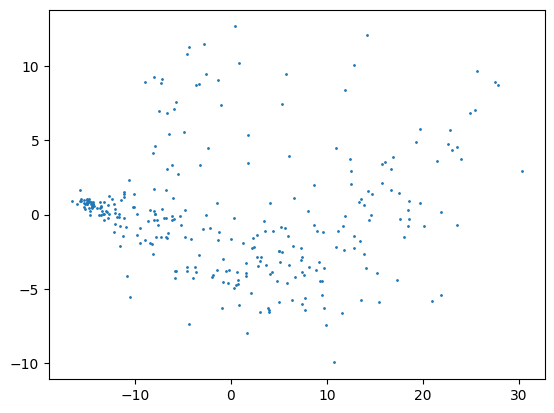

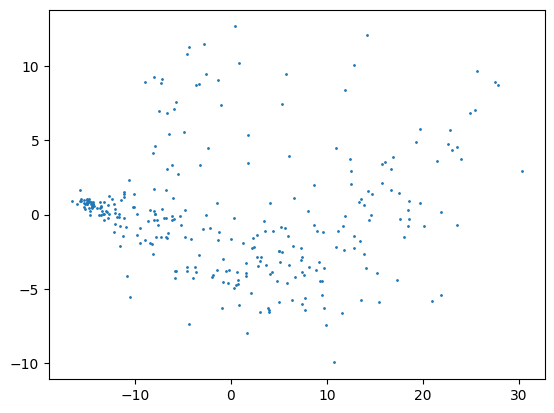

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
coords = pca.fit_transform(new_frames.squeeze())
plt.scatter(coords[:, 0], coords[:, 1], s=1)
plt.show()
pca = PCA()
coords = pca.fit_transform(frames.squeeze())
plt.scatter(coords[:, 0], coords[:, 1], s=1)